In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV,KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , OneHotEncoder 
from sklearn.metrics import mean_squared_log_error

# np.sqrt(mean_squared_log_error(actual, predicted))

import xgboost as xgb

In [2]:
train_df =  pd.read_csv('https://raw.githubusercontent.com/benvictoria21/pandas/master/dataset/ParticipantData_BTPC/Train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/benvictoria21/pandas/master/dataset/ParticipantData_BTPC/Test.csv')

In [3]:
train_df.head()

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
0,57f879e70d3c5fc2a98102d64c9fd84e,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0,236.886
1,a5442b0c7c33d0a811e7661e556b2de8,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0,1277.455
2,305cb1486ed8610c00b37007926cb2c4,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,0,0,0,21.704
3,f2c1ecc9993f0071df91ba178450498c,2794,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2019-12-30,0,1,0,455.201
4,e460830ae295e55d2216ebdc761ab9a6,3674,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,2019-09-10,0,0,0,1164.877


In [4]:
test_df.head()

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out
0,0bf72b05b2cf70dc5e28c3c09f9c4f97,99,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,Desktop - IE,2020-01-07,1,0,0
1,6bc696d99954e4f1367e845465186aef,935,Product/160393 Android/4.3 Device/samsung_GT-I...,Android Phone - Android,2020-02-13,0,0,0
2,3d8611a5ea0f621d205b67f09f663a89,902,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-10-14,1,0,0
3,a0351545c032fd0da36289410c6c3354,3223,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2020-01-26,0,0,0
4,dd8999772b0ab27225fb05e5df2f1da6,231,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-29,0,0,0


In [5]:
len(pd.unique(train_df['session_id']))==len(train_df)

True

In [6]:
train = train_df.copy()
test = test_df.copy()

In [7]:
train = train.drop(labels=['session_id','client_agent'],axis = 1)
test = test.drop(labels=['session_id','client_agent'],axis = 1)
train['device_details'].value_counts()

iPhone - iOS                  1515
Desktop - Chrome               815
iPhone - Web                   665
Android Phone - Android        326
Desktop - Safari               313
Desktop - IE                   292
iPad - Web                     289
iPhone - MobileWeb             277
Desktop - Firefox              234
Android Tablet - Web           203
Other - Other                  185
Unknown - MobileWeb             87
Android Phone - Web             86
iPad - iOS                      77
Android Phone - MobileWeb       54
Android Tablet - Android         9
Android Tablet - MobileWeb       2
Name: device_details, dtype: int64

In [8]:
train.describe()

,session_number,purchased,added_in_cart,checked_out,time_spent
count,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000
mean,1072.835329,0.159145,0.162092,0.017499,663.194292
std,1436.351474,0.365845,0.368570,0.131132,1713.671664
min,11.000000,0.000000,0.000000,0.000000,14.400000
25%,121.000000,0.000000,0.000000,0.000000,22.699000
50%,517.000000,0.000000,0.000000,0.000000,98.312000
75%,1397.000000,0.000000,0.000000,0.000000,600.463000
max,7722.000000,1.000000,1.000000,1.000000,38494.025000


In [9]:
train['session_number'].value_counts()

11      437
22      192
33      132
44      101
55       93
       ... 
3949      1
3696      1
5962      1
7601      1
6083      1
Name: session_number, Length: 610, dtype: int64

In [10]:
train["date"] = pd.to_datetime(train['date'])
test["date"] = pd.to_datetime(test['date'])

train["year"] = train['date'].dt.year
test["year"] = test['date'].dt.year

train["month"] = train['date'].dt.month
test["month"] = test['date'].dt.month

train['day']= train['date'].dt.day
test["day"] = test['date'].dt.day

train['diff_date'] = ((train['date'] - pd.datetime(1970,1,1)).dt.total_seconds())/(10**6)
test['diff_date'] = ((test['date'] - pd.datetime(1970,1,1)).dt.total_seconds())/(10**6)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [11]:
train.head()

,session_number,device_details,date,purchased,added_in_cart,checked_out,time_spent,year,month,day,diff_date
0,715,Desktop - Chrome,2020-01-22,1,0,0,236.886,2020,1,22,1579.6512
1,55,iPhone - iOS,2020-02-27,1,0,0,1277.455,2020,2,27,1582.7616
2,11,iPhone - MobileWeb,2019-08-01,0,0,0,21.704,2019,8,1,1564.6176
3,2794,Desktop - IE,2019-12-30,0,1,0,455.201,2019,12,30,1577.6640
4,3674,iPhone - Web,2019-09-10,0,0,0,1164.877,2019,9,10,1568.0736


In [12]:
l = pd.unique(train["device_details"])
device_encoding = {}
x = 0
for i in l:
    if i not in device_encoding:
        device_encoding[i] = x
        x+=1
print(device_encoding)

train["device_encoding"] = train["device_details"].map(device_encoding)
test["device_encoding"] = test["device_details"].map(device_encoding)

{'Desktop - Chrome': 0, 'iPhone - iOS': 1, 'iPhone - MobileWeb': 2, 'Desktop - IE': 3, 'iPhone - Web': 4, 'Android Phone - Android': 5, 'Desktop - Firefox': 6, 'Android Tablet - Web': 7, 'iPad - Web': 8, 'Other - Other': 9, 'Desktop - Safari': 10, 'Android Phone - Web': 11, 'iPad - iOS': 12, 'Android Phone - MobileWeb': 13, 'Unknown - MobileWeb': 14, 'Android Tablet - Android': 15, 'Android Tablet - MobileWeb': 16}


In [13]:
train.head()

,session_number,device_details,date,purchased,added_in_cart,checked_out,time_spent,year,month,day,diff_date,device_encoding
0,715,Desktop - Chrome,2020-01-22,1,0,0,236.886,2020,1,22,1579.6512,0
1,55,iPhone - iOS,2020-02-27,1,0,0,1277.455,2020,2,27,1582.7616,1
2,11,iPhone - MobileWeb,2019-08-01,0,0,0,21.704,2019,8,1,1564.6176,2
3,2794,Desktop - IE,2019-12-30,0,1,0,455.201,2019,12,30,1577.6640,3
4,3674,iPhone - Web,2019-09-10,0,0,0,1164.877,2019,9,10,1568.0736,4


In [14]:
train= train[pd.notnull(train["time_spent"])]

In [15]:
# cols = ['session_number','device_encoding','purchased','added_in_cart','checked_out','year','month','day','diff_date']
cols = ['session_number','purchased','added_in_cart','checked_out']
X = train[cols]
Y = train["time_spent"]

In [16]:
Y

0        236.886
1       1277.455
2         21.704
3        455.201
4       1164.877
          ...   
5424      20.601
5425    1537.666
5426      22.711
5427      20.844
5428      20.504
Name: time_spent, Length: 5429, dtype: float64

In [17]:
X

,session_number,purchased,added_in_cart,checked_out
0,715,1,0,0
1,55,1,0,0
2,11,0,0,0
3,2794,0,1,0
4,3674,0,0,0
...,...,...,...,...
5424,627,0,0,0
5425,6710,0,0,0
5426,198,0,0,0
5427,913,0,0,0


In [18]:
x_tr,x_tst,y_tr,y_tst = train_test_split(X,Y,test_size=0.3,random_state=6969)
xgr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6594975539639095, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.01634714303249965, max_delta_step=0, max_depth=9,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.42320618378477715, tree_method='exact',
             validate_parameters=1, verbosity=2)
xgr.fit(X=x_tr[cols],y=y_tr,eval_set=[(x_tr[cols],y_tr)],eval_metric="rmse",verbose=2)
ans = abs(xgr.predict(x_tst))
score = np.sqrt(mean_squared_log_error(y_tst, ans))
score

[18:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-rmse:1889.17602
[18:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=9
[18:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-rmse:1878.47083
[18:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=9
[18:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[4]	validation_0-rmse:1866.99548
[18:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=9
[18:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=9
[6]	validation_0-rmse:1849.11462
[18:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra

1.9625277097926463

In [19]:
train.corr().time_spent

session_number     0.078437
purchased          0.200762
added_in_cart      0.209807
checked_out        0.157765
time_spent         1.000000
year              -0.030843
month              0.013367
day               -0.030206
diff_date         -0.046154
device_encoding   -0.020000
Name: time_spent, dtype: float64

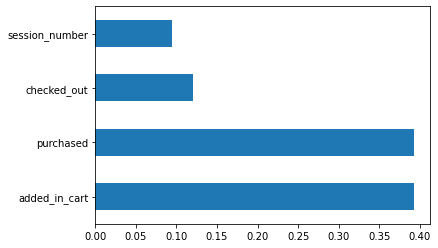

In [20]:
feat_importances = pd.Series(xgr.feature_importances_, index=cols)
feat_importances.nlargest(6).plot(kind='barh')
plt.show()

In [21]:
xgr.fit(X=X[cols],y=Y,verbose=2)
ans = xgr.predict(test[cols])

[18:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=9
[18:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[18:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=9
[18:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes

In [22]:
sub = pd.read_csv('https://raw.githubusercontent.com/benvictoria21/pandas/master/dataset/ParticipantData_BTPC/Sample%20Submission.csv')
sub["time_spent"]=abs(ans)
sub.to_csv('sub1_xgb1.csv', index=False)